In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

## Following the guide to collect dataset

http://trillium.tech/ml4floods/content/ml4ops/HOWTO_Train_models.html#step-2-setup-dataloader

In [2]:
import sys, os
from pathlib import Path

## Step 1: Setup Configuration file

In [3]:
from ml4floods.models.config_setup import get_default_config
import pkg_resources

# Set filepath to configuration files
# config_fp = 'path/to/worldfloods_template.json'
config_fp = pkg_resources.resource_filename("ml4floods","models/configurations/worldfloods_template.json")

config = get_default_config(config_fp)

Loaded Config for experiment:  worldfloods_demo_test
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4cc_data_lake',
                       'channel_configuration': 'all',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': 'worldfloods',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]}

## Step 1.a: Seed everything for reproducibility

In [4]:
from pytorch_lightning import seed_everything
# Seed
seed_everything(config.seed)

Global seed set to 12


12

## Step 1.b: Make it a unique experiment

In [5]:
config.experiment_name = 'training_demo'

## Step 2: Setup Dataloader

In [6]:
%%time

from ml4floods.models.dataset_setup import get_dataset

config.data_params.batch_size = 16 # control this depending on the space on your GPU!
config.data_params.loader_type = 'local'
config.data_params.path_to_splits = "/mnt/d/Flooding/worldfloods_v1_sample" # local folder to download the data
# config.data_params.train_test_split_file = "2_PROD/2_Mart/worldfloods_v1_0/train_test_split_sample.json"

config.data_params["download"] = {"train": True, "val": True, "test": False} # download only test data
config.data_params.train_test_split_file = "2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json" # use this to train with all the data

# If files are not in config.data_params.path_to_splits this will trigger the download of the products.
dataset = get_dataset(config.data_params)

Using local dataset for this run
Skip download test
train 194151  tiles
val 1284  tiles
test 11  tiles
CPU times: user 4.86 s, sys: 2.9 s, total: 7.76 s
Wall time: 13.4 s


## Show some images from the dataloader¶

The dataset object is a pytorch_lightining DataModule object. This object has the WorldFloods train, val and test datasets as attributes (dataset.train_dataset, dataset.val_dataset and dataset.test_dataset). In addition we can create pytorch DataLoaders from them using the methods train_dataloader(), val_dataloader() and test_dataloader().

In [7]:
train_dl = dataset.train_dataloader()

train_dl_iter = iter(train_dl)
batch = next(train_dl_iter)

batch["image"].shape, batch["mask"].shape

(torch.Size([16, 13, 256, 256]), torch.Size([16, 1, 256, 256]))

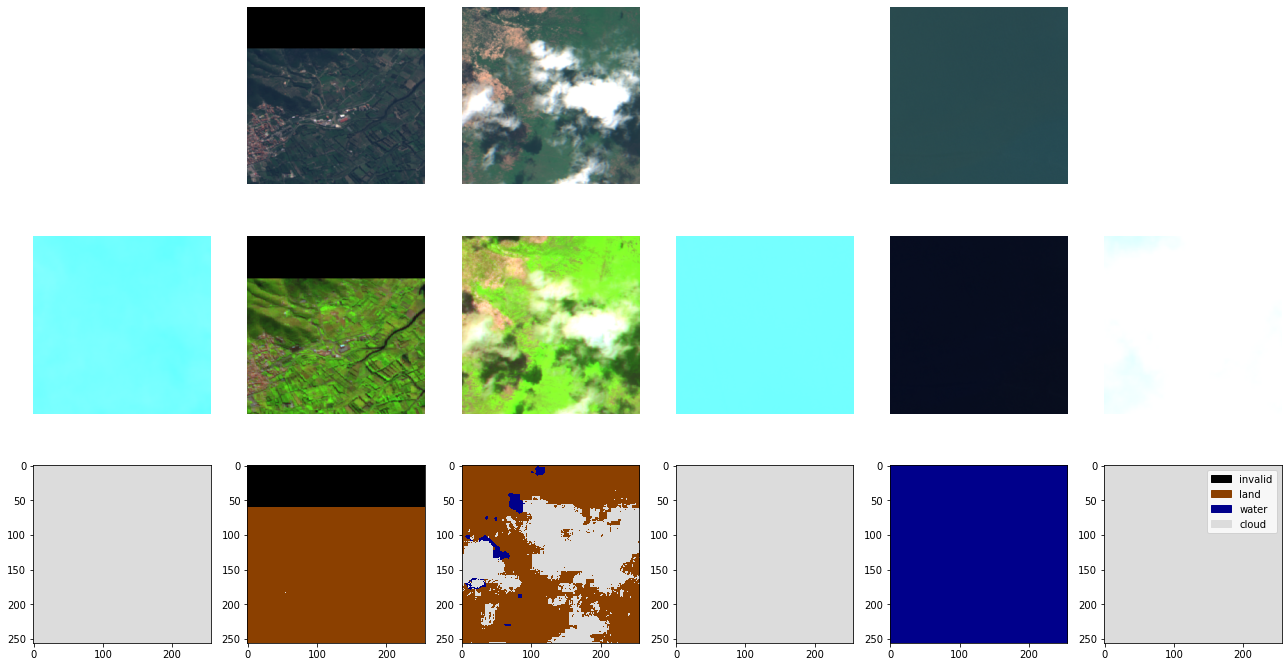

In [8]:
from ml4floods.models import worldfloods_model
import matplotlib.pyplot as plt

n_images=6
fig, axs = plt.subplots(3,n_images, figsize=(18,10),tight_layout=True)
worldfloods_model.plot_batch(batch["image"][:n_images],axs=axs[0],max_clip_val=3500.)
worldfloods_model.plot_batch(batch["image"][:n_images],bands_show=["B11","B8", "B4"],
                             axs=axs[1],max_clip_val=4500.)
worldfloods_model.plot_batch_output_v1(batch["mask"][:n_images, 0],axs=axs[2], show_axis=True)

## Step 3: Setup Model

In [9]:
 # folder to store the trained model (it will create a subfolder with the name of the experiment)
config.model_params

{'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 256,
  'metric_monitor': 'val_dice_loss',
  'channel_configuration': 'all',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'linear',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'early_stopping_patience': 4,
  'num_channels': 13},
 'train': True,
 'test': True}

In [10]:
from ml4floods.models.model_setup import get_model

config.model_params.model_folder = "models" 
os.makedirs("models", exist_ok=True)
config.model_params.test = False
config.model_params.train = True
config.model_params.hyperparameters.model_type = "simplecnn" # Currently implemented: simplecnn, unet, linear
model = get_model(config.model_params)
model

WorldFloodsModel(
  (network): SimpleCNN(
    (conv): Sequential(
      (0): Sequential(
        (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

## Step 4: (Optional) Set up Weights and Biases Logger for experiment

In [11]:
setup_weights_and_biases = False
if setup_weights_and_biases:
    import wandb
    from pytorch_lightning.loggers import WandbLogger

    # UNCOMMENT ON FIRST RUN TO LOGIN TO Weights and Biases (only needs to be done once)
    # wandb.login()
    # run = wandb.init()

    # Specifies who is logging the experiment to wandb
    config['wandb_entity'] = 'ml4floods'
    # Specifies which wandb project to log to, multiple runs can exist in the same project
    config['wandb_project'] = 'worldfloods-notebook-demo-project'

    wandb_logger = WandbLogger(
        name=config.experiment_name,
        project=config.wandb_project, 
        entity=config.wandb_entity
    )
else:
    wandb_logger = None

## Step 5: Setup Lightning Callbacks

In [12]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

experiment_path = f"{config.model_params.model_folder}/{config.experiment_name}"

checkpoint_callback = ModelCheckpoint(
    dirpath=f"{experiment_path}/checkpoint",
    save_top_k=True,
    verbose=True,
    monitor='val_dice_loss',
    mode='min',
#     prefix=''
)

early_stop_callback = EarlyStopping(
    monitor='val_dice_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)

callbacks = [checkpoint_callback, early_stop_callback]

print(f"The trained model will be stored in {config.model_params.model_folder}/{config.experiment_name}")

The trained model will be stored in models/training_demo


/home/eeaiserver/pt-gpu/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory models/training_demo/checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


## Step 6: Setup Lighting Trainer

In [13]:
from pytorch_lightning import Trainer

config.gpus = '0'  # which gpu to use

# config.gpus = None # to not use GPU

config.model_params.hyperparameters.max_epochs = 4 # train for maximum 4 epochs

trainer = Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    callbacks=callbacks,
    default_root_dir=f"{config.model_params.model_folder}/{config.experiment_name}",
    accumulate_grad_batches=1,
    gradient_clip_val=0.0,
    auto_lr_find=False,
    benchmark=False,
    distributed_backend=None,
    gpus=config.gpus,
    max_epochs=config.model_params.hyperparameters.max_epochs,
    check_val_every_n_epoch=config.model_params.hyperparameters.val_every,
    log_gpu_memory=True,
    resume_from_checkpoint=None
)

/home/eeaiserver/pt-gpu/lib/python3.8/site-packages/pytorch_lightning/utilities/device_parser.py:130: LightningDeprecationWarning: Parsing of the Trainer argument gpus='0' (string) will change in the future. In the current version of Lightning, this will select CUDA device with index 0, but from v1.5 it will select gpus [] (same as gpus=0 (int)).
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [14]:
trainer.fit(model, dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type      | Params
--------------------------------------
0 | network | SimpleCNN | 266 K 
--------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.065     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/eeaiserver/pt-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 12


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 12134: val_dice_loss reached 0.40725 (best 0.40725), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/data/models/training_demo/checkpoint/epoch=0-step=12134.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 24269: val_dice_loss reached 0.38425 (best 0.38425), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/data/models/training_demo/checkpoint/epoch=1-step=24269.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 36404: val_dice_loss reached 0.38350 (best 0.38350), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/data/models/training_demo/checkpoint/epoch=2-step=36404.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 48539: val_dice_loss reached 0.37397 (best 0.37397), saving model to "/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/data/models/training_demo/checkpoint/epoch=3-step=48539-v1.ckpt" as top True


## Step 7: Eval model

In [15]:
import torch
# Run inference on the images shown before

logits = model(batch["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of logits: torch.Size([16, 3, 256, 256])
Shape of probs: torch.Size([16, 3, 256, 256])
Shape of prediction: torch.Size([16, 256, 256])


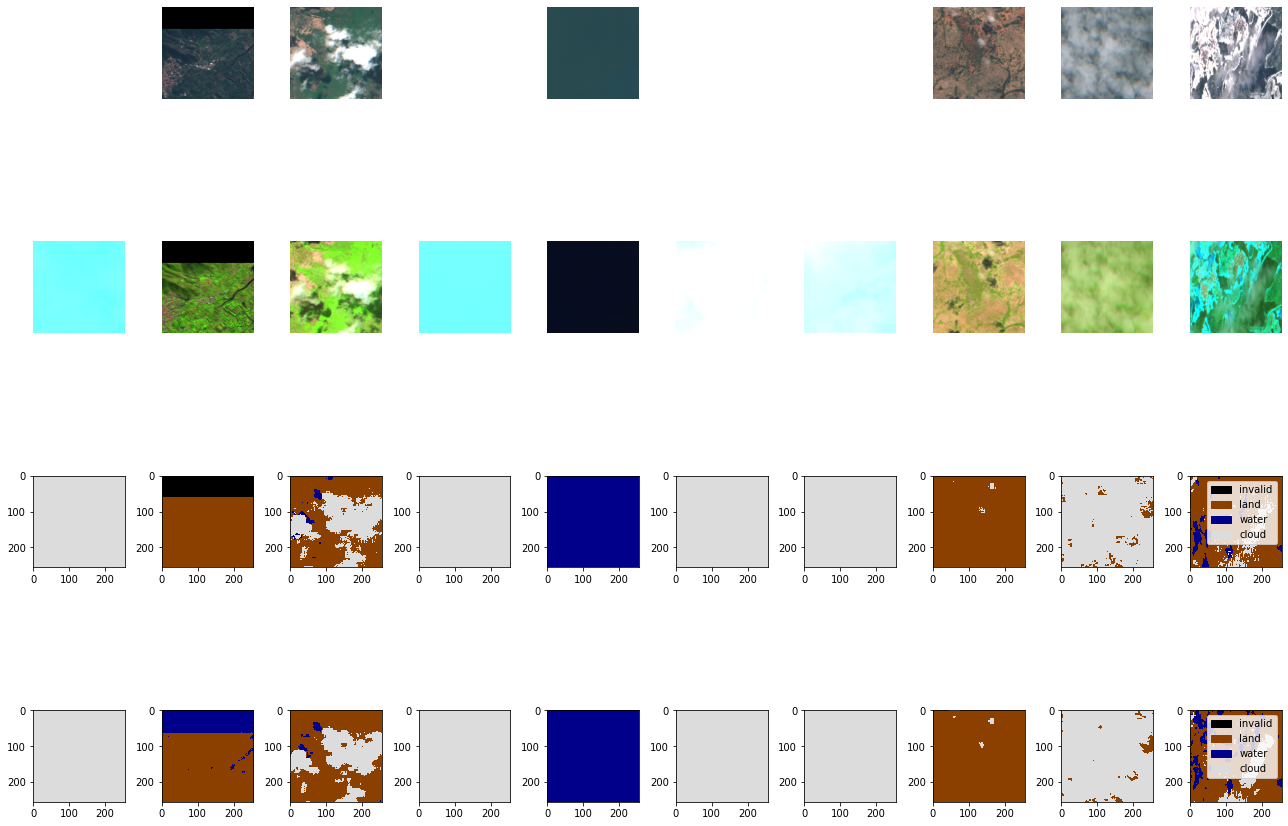

In [16]:
n_images=10
fig, axs = plt.subplots(4, n_images, figsize=(18,14),tight_layout=True)
worldfloods_model.plot_batch(batch["image"][:n_images],axs=axs[0],max_clip_val=3500.)
worldfloods_model.plot_batch(batch["image"][:n_images],bands_show=["B11","B8", "B4"],
                             axs=axs[1],max_clip_val=4500.)
worldfloods_model.plot_batch_output_v1(batch["mask"][:n_images, 0],axs=axs[2], show_axis=True)
worldfloods_model.plot_batch_output_v1(prediction[:n_images] + 1,axs=axs[3], show_axis=True)

for ax in axs.ravel():
    ax.grid(False)

## Eval in the val dataset

In [17]:
import numpy as np
from ml4floods.models.utils import metrics
from ml4floods.models.model_setup import get_model_inference_function
import pandas as pd

model.to("cuda")
inference_function = get_model_inference_function(model, config, apply_normalization=False, 
                                                  activation="softmax")

dl = dataset.val_dataloader() # pytorch Dataloader

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    thresholds_water=thresholds_water, 
    plot=False)

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)

Getting model inference function


AttributeError: 'AttrDict' object has no attribute 'max_tile_size'

## Show results for each flood event in the validation dataset

In [ ]:
if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in ["land", "water", "cloud"]]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in ["land", "water", "cloud"]]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

## Step 8: Save trained model

In [ ]:
import torch
from pytorch_lightning.utilities.cloud_io import atomic_save
from ml4floods.models.config_setup import save_json

# Save in the cloud and in the wandb logger save dir
atomic_save(model.state_dict(), f"{experiment_path}/model.pt")
# Save cofig file in experiment_path
config_file_path = f"{experiment_path}/config.json"
save_json(config, config_file_path)

## Optional: Save weights and biases model and finish connection

In [ ]:
if setup_weights_and_biases:
    torch.save(model.state_dict(), os.path.join(wandb_logger.save_dir, 'model.pt'))
    wandb.save(os.path.join(wandb_logger.save_dir, 'model.pt')) # Copy weights to weights and biases server
    wandb.finish()